# SI 370 - Lab Session 11.1: Text Data
## Objectives:
Knows how to use Python to
- load and preprocess text files
- calculate TFIDF weights
- perform basic a classification task (spam vs. non-spam) 
- perform basic sentiment analysis
- perform topic modeling using LDA

<img src="abstract.png">

<img src="text_type.png" >

<img src="text_analysis_level.png">

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
import sklearn.ensemble as skens
import sklearn.metrics as skmetrics
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from IPython.core.display import HTML
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import sklearn.cross_validation as skcv
import sklearn.decomposition as skd
import sklearn.feature_extraction.text as skft
import sklearn.pipeline as skpipe
import nltk
from nltk.tokenize import RegexpTokenizer
import math
from nltk.corpus import stopwords
import collections
import os
from collections import Counter
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph

# make the Pandas tables a little more readable
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))


/Users/AJGoldstein/anaconda/envs/si370/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

#  Basic Text

In [4]:
# new working sentence
s = "Good muffins cost $3.88 in New York. I didn't know that. Thanks, Mr. Smith"

Regular Expressions Online Tool: https://regex101.com/

Tokenization: Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens

Types: unique tokens

In [5]:
regex_tokenizer = nltk.RegexpTokenizer(r'(\w+)')
wordlist = regex_tokenizer.tokenize(s)
# breaking apart into more (slightly) logical units
wordlist

['Good',
 'muffins',
 'cost',
 '3',
 '88',
 'in',
 'New',
 'York',
 'I',
 'didn',
 't',
 'know',
 'that',
 'Thanks',
 'Mr',
 'Smith']

Question: Write another regex to capture '$3.88' as a whole token

Answer:

In [6]:
wordlist = nltk.tokenize.word_tokenize(s)  
# breaking apart into more (slightly) logical units
wordlist

['Good',
 'muffins',
 'cost',
 '$',
 '3.88',
 'in',
 'New',
 'York',
 '.',
 'I',
 'did',
 "n't",
 'know',
 'that',
 '.',
 'Thanks',
 ',',
 'Mr.',
 'Smith']

In [7]:
wordlist = nltk.tokenize.wordpunct_tokenize(s)  
# breaking apart into more (slightly) logical units
wordlist

['Good',
 'muffins',
 'cost',
 '$',
 '3',
 '.',
 '88',
 'in',
 'New',
 'York',
 '.',
 'I',
 'didn',
 "'",
 't',
 'know',
 'that',
 '.',
 'Thanks',
 ',',
 'Mr',
 '.',
 'Smith']

### Stemming

In [8]:
stemmer = nltk.stem.snowball.EnglishStemmer()  # grab me a "snowball stemmer"

In [9]:
stemmer.stem('running')  # stem the word running

'run'

In [10]:
stemmer.stem('runs')

'run'

In [11]:
stemmer.stem('applied')  # not proper English

'appli'

In [12]:
stemmer.stem('apply')  # but same as above

'appli'

### Remove Stopwords

In [13]:
swords = stopwords.words('english')  # basic stopword library
print(stopwords.words('english')[:5])
# can always add your own

['i', 'me', 'my', 'myself', 'we']


In [14]:
t = s.lower()   # lowercase
sent = nltk.tokenize.wordpunct_tokenize(t)
new_sent = []  # this will hold our NON-stopword wods
for w in sent:   # for each word
    if w not in stopwords.words('english'):  # if not in stopword list
        new_sent.append(w)  # collect the word

print(new_sent)

['good', 'muffins', 'cost', '$', '3', '.', '88', 'new', 'york', '.', "'", 'know', '.', 'thanks', ',', 'mr', '.', 'smith']


In [15]:
# shorthand version
# split and lower case
tokens = [w.lower() for w in s.split()] 
print(tokens)
# remove stopwords (or keep those not in stopword list)
tokens = [w for w in tokens if w not in swords]
print(tokens)

['good', 'muffins', 'cost', '$3.88', 'in', 'new', 'york.', 'i', "didn't", 'know', 'that.', 'thanks,', 'mr.', 'smith']
['good', 'muffins', 'cost', '$3.88', 'new', 'york.', "didn't", 'know', 'that.', 'thanks,', 'mr.', 'smith']


### Distributions

Word Count Visualization: http://www.wordcount.org/main.php

In [16]:
booklist = !ls stories   #all my fairy tales

tales = pd.DataFrame()
tales['file'] = ""
tales['content'] = ""

# we'll read everything into a dataframe
for i in range(0,len(booklist)):
    with open('stories/'+booklist[i],"r") as myfile:  # connect first file to myfile (handle object, r = read only)
        data = myfile.read().replace('\n',' ')  # read in the file, replace newlines with space
    tales.set_value(i,"file",booklist[i])
    tales.set_value(i,"content",data)

tales.head()

file  \
0                   A_THE BELL.txt   
1    A_THE DREAM OF LITTLE TUK.txt   
2              A_THE ELDERBUSH.txt   
3  A_THE EMPEROR'S NEW CLOTHES.txt   
4           A_THE FALSE COLLAR.txt   

                                             content  
0  THE BELL  People said "The Evening Bell is sou...  
1  THE DREAM OF LITTLE TUK  Ah! yes, that was lit...  
2  THE ELDERBUSH  Once upon a time there was a li...  
3  THE EMPEROR'S NEW CLOTHES  Many years ago, the...  
4  THE FALSE COLLAR  There was once a fine gentle...

In [17]:
# grab the first story
data = tales.content[0]

# print out the first 300 characters
print(data[:300])  

THE BELL  People said "The Evening Bell is sounding, the sun is setting." For a strange wondrous tone was heard in the narrow streets of a large town. It was like the sound of a church-bell: but it was only heard for a moment, for the rolling of the carriages and the voices of the multitude made too


In [18]:
# tokenized and made lowercase (haven't stemmed and haven't removed stopwords)
words = [w.lower() for w in nltk.tokenize.wordpunct_tokenize(data)]

Question: change the last line to stem and remove stopwords

In [19]:
#Answer:
words = [stemmer.stem(w) for w in words if w not in stopwords.words('english')]

In [20]:
import string
print(string.punctuation) # show me which things are in punctuation
# remove punctuation
words = [w for w in words if w not in string.punctuation]
print(words[0:10])

# remove stopwords
words = [w for w in words if w not in swords]
print(words[0:10])

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['bell', 'peopl', 'said', 'even', 'bell', 'sound', 'sun', 'set', '."', 'strang']
['bell', 'peopl', 'said', 'even', 'bell', 'sound', 'sun', 'set', '."', 'strang']


In [21]:
# find how often each word appears
fd = nltk.probability.FreqDist(words)  

In [22]:
# get the most common (top 20)
print(fd.most_common(20))

[('bell', 25), ('said', 16), ('sound', 15), ('tree', 13), ('go', 12), ('one', 11), ('son', 11), ('sun', 10), ('wood', 10), ('king', 10), ('peopl', 9), ('tone', 8), ('heard', 8), ('larg', 8), ('could', 8), ('still', 8), ('long', 8), ('confirm', 8), ('came', 7), ('went', 7)]


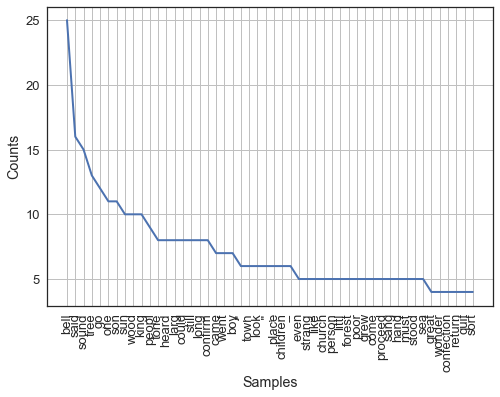

In [23]:
fd.plot(50)  # show me a frequency plot  50 = top 50 (otherwise all)

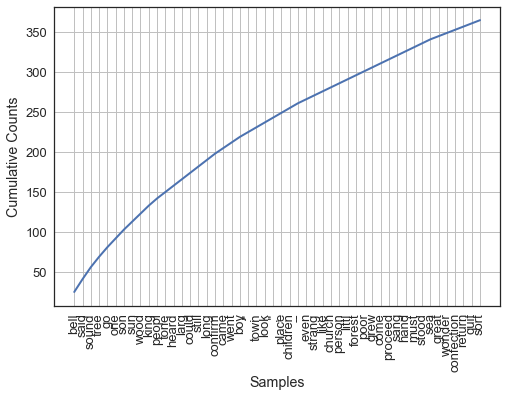

In [24]:
fd.plot(50, cumulative=True)

### Zipf's Law

(quoted from Bird, Klearn & Loper _Natural Language Processing with Python_ (2009)):
> Let $f(w)$ be the frequency of a word $w$ in free text. Suppose that all the words of a text are ranked according to their frequency, with the most frequent word first. Zipf's Law states taht the frequency of a word type is inversely proportional to its rank (i.e., $f\times r=k$, for some constant $k$). For example, the 50th most common word type should occurr three times as frequently as the 150th most common word type.

Now we will explore whether this law holds for our email dataset. If the law holds, we should observe a straight line in the following image.

<img src='zipfs_law.png'>


In [25]:
# grab all the stories
allstories = ' '.join(tales.content.values)

# tokenize
words = [w.lower() for w in nltk.tokenize.wordpunct_tokenize(allstories)]

# remove punctuation
words = [w for w in words if w not in string.punctuation]

# calculate the frequencies
fd = nltk.probability.FreqDist(words) 

In [26]:
# Plot the Zipf's Law.
sorted_frequencies = sorted(fd.values(), reverse=True)

# TODO: populate xs, which should be an array, [1,2,3,...,len(sorted_frequencies)]
xs = np.arange(len(sorted_frequencies)) + 1


plt.loglog(xs, sorted_frequencies, 'o')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Zipf\'s Law');

### Calculate TFIDF

<img src="vector_space_coordinate.png",width=500, height=100>

<img src="document_term_matrix.jpg",width=700, height=100>

<img src='tfidf.png'>

In [27]:
def tfidf(t,d,D):     # take a term, t, document, d, and collection, D
    tf = float(d.count(t))  # count the number of times t appears in d
    N = float(len(D))
    dt = len([doc for doc in D if t in doc])  # find all documents that contain t, count the length
    idf = math.log(N/dt)
    return tf * idf   # return the value

In [28]:
# declare 3 documents
a, abb, abc = ["a"],["a","b","b"],["a","b","c"]
# make our collection
D = [a,abb,abc]

In [29]:
print(tfidf("a",a,D))  # weight for term a in document a for collection D
print(tfidf("a",abb,D))
print(tfidf("b",abb,D))
print(tfidf("b",abc,D))

0.0
0.0
0.8109302162163288
0.4054651081081644


Question: What are some examples of a and c in a typical document?

Answer: 

# Using `scikit-learn`'s vectorizer

The `scikit-learn`'s `CountVectorizer` does lowercasing and tokenization, as well as frequency counting automatically. We will use this class to help us preprocess our dataset and extract features.

In [30]:
'''Lesson: to create a vectorizer:
    
      vectorizer = skft.CountVectorizer(options...)

   There are a number of options available to control the behavior of the vectorizer.
   Execute skft.CountVectorizer? to study the options.
'''

# TODO: Create a vectorizer with max_df=0.7
vectorizer = skft.CountVectorizer(max_df=0.7)

CountVectorizer parameters:
<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [31]:
'''Lesson: to transform an array of text data into vectors, use

       vectorizer.fit_transform(arr)
       
   where arr is the array of text documents.
'''

# TODO: use the vectorizer to fit and transform df_email_train.content into X_train.
tf_tales = vectorizer.fit_transform(tales.content)

In [32]:
# python uses a special data type for text of this type
tf_tales 

<43x6374 sparse matrix of type '<class 'numpy.int64'>'
	with 20926 stored elements in Compressed Sparse Row format>

In [33]:
# each row is a story, each column is the # of times some word
# appears in the story (the columns are randomly arranged)
tf_tales_array = tf_tales.toarray() 
tf_tales_array

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [34]:
# the vectorizer remembers where certain features (columns)
# are.  For example, if we want to know which words correspond
# to columns 5 through 20, we would do:
vectorizer.get_feature_names()[5:20]

['1807',
 '2000',
 '_here_',
 'abandoned',
 'abashed',
 'able',
 'abode',
 'above',
 'abroad',
 'absalon',
 'absence',
 'absent',
 'absolutely',
 'absorbed',
 'abundance']

In [35]:
# if we wanted to know which column contained "bell"
vectorizer.get_feature_names().index("bell")

458

In [36]:
# so we can find the number of times bell is used
# in the first story (the bell). Remember we calculated this to be 
# 25 before...
tf_tales.toarray()[0][458]

25

In [37]:
vectorizer.get_feature_names().index('agony')

103

In [38]:
tf_tales.toarray()[2][103]

0

Question: What is the number of times 'agony' is used in the third story

Answer: 0

## Similarity Metrics

<ul> Tells us how similar text 1 is to text 2
<li> Document to document
<li> Sentence to sentence
<li> “query” to document
</ul>

In [39]:
# compute cosine similarity between fairytale 1 and fairytale 2 
tf_tales_df = pd.DataFrame(tf_tales_array)
spd.cosine(tf_tales_df.iloc[0],tf_tales_df.loc[1])

0.77331162863390523

In [40]:
# compute Jaccard distance between fairytale 1 and fairytale 2 

## Hierarchical Clustering Again !

0  1  2  3  4  5  6  7  8  9      ...        6365  6366  6367  6368  6369  \
0  0  0  0  0  0  0  0  0  0  0      ...           0     0     1     0     0   
1  0  0  0  0  0  1  1  0  0  0      ...           1     1     0     0     0   
2  0  0  0  0  0  0  0  0  0  0      ...           3     0     1     0     0   
3  0  0  0  0  0  0  0  0  0  0      ...           0     0     0     0     0   
4  0  0  0  0  0  0  0  0  0  0      ...           1     0     0     0     0   

   6370  6371  6372  6373  cluster_label  
0     0     1     0     0              3  
1     0     0     3     0              3  
2     0     0     0     0              1  
3     0     0     0     0              3  
4     0     0     0     0              3  

[5 rows x 6375 columns]

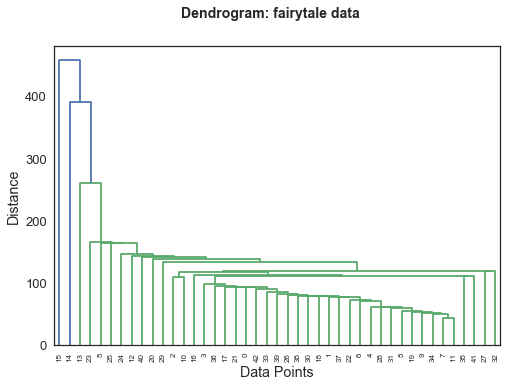

In [41]:
# To perform hierarchical clustering, the first step is to compute 
# the distance matrix. We will be using the Euclidean distance.
dist_xy = spd.squareform(spd.pdist(tf_tales_df,metric='euclidean'))
dist_xy.shape

# Perform hierarchical clustering and plot the dendrogram.
Z_xy = sph.linkage(dist_xy,method='single')
_ = sph.dendrogram(Z_xy)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram: fairytale data', 
             fontweight='bold', fontsize=14);

cluster_labels = sph.fcluster(Z_xy,100,criterion='distance')
tf_tales_df['cluster_label'] = cluster_labels
tf_tales_df.head()

## Topic Modeling

Topic modeling is a fancy kind of PCA/clustering for text.  You tell it how many topics to consider and the word vectors.

<img src="Topic_Model.png",width=700, height=100>

In [42]:
# Run LDA on the tales dataset.
n_features = 1000
n_topics = 10
n_top_words = 20

# "we're going to use the same code as above with a few changes. We want to limit the frequency... 
# so let's keep around only words that appear in more than two document but in less than 70%
# let's also restrict ourselves to 1000 words and remove stopwords
tf_vectorizer = skft.CountVectorizer(max_df=0.7, min_df=2, max_features=n_features, stop_words='english')
tf_tales = tf_vectorizer.fit_transform(tales.content)

In [43]:
# this runs the topic modelling algorithm. It may take a little bit of time to run
# depending on how much data you have (when you run "fit"). 
# We'll tell it how many loops (iters) to go
# and how many topics.  This will create the learning "object"
lda = skd.LatentDirichletAllocation(n_topics=n_topics, 
                                    max_iter=10,
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0)

Question: How do we look up what the LDA parameters mean in an inline code?

Answer:

In [44]:
'''TODO: Fit the LDA model using:
        
        lda.fit(tf_reviews);
        
   This may take a while running in the backend
'''
# this will actually run the algorithm
lda.fit(tf_tales);

In [45]:
# a helper function to print the topics and the top words in each
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print("Topics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topics in LDA model:
Topic #0:
king tree queen princess white snow world thou tell round child eyes got heart wood oh room young gold large
Topic #1:
king daughter water queen replied forest prince castle father sister woman maiden brothers night life morning golden set dear bread
Topic #2:
children king white wood faithful snow bell mother death red bear rose thy dwarf child saying large trees frog young
Topic #3:
emperor father shiver thumb youth learn snail house clothes oh cloth forest new means work men world fellow colors black
Topic #4:
tailor tree giant seven blow carry branches large trees sleep house lay ground got ran forest wild nice hold till
Topic #5:
cap wolf red grandmother meat bed eyes flowers better trees open looking exclaimed nice cottage woman going dear met walk
Topic #6:
tree eyes snow mother princess large white house boy yes woman thou oh got queen shoes tell knew red look
Topic #7:
learned thou say master emperor yes king stranger world work tell father balco

There isn't a ton of data here, so the topics aren't super, but you can see some patterns...

You can also play with the number of topics to see if this works better.  We'll see better examples of this below.

Question: What is the major difference of LDA (topic model) vs. K-means or Hierarchical Clustering?

Answer: K-means is going to partition the N documents in K disjoint clusters (i.e. topics in this case). On the other hand, LDA assigns a document to a mixture of topics. Therefore each document is characterized by one or more topics (e.g. Document D belongs for 60% to Topic A, 30% to topic B and 10% to topic E). Hence, LDA can give more realistic results than k-means for topic assignment.

# Comparing Two Classes: Ham and Spam

Take a minute to look at the directory structure for enron. These are emails collected from the company when they went bust (or more accurately, were busted). There are two subfolders, `ham` and `spam`, containing non-spam and spam emails respectively. Each file contains an email, including its subject and body text. The other fields of the email, such as the sender and recipients, have been removed.

The following code loads all emails into memory as a single `DataFrame`. Try to understand how it works.

In [46]:
titles = []
contents = []
labels = []
import os
for label in ['ham', 'spam']:
    for f in os.listdir(os.path.join('enron',label)):
        with open(os.path.join('enron', label, f), 'r') as reader:
            try:
                c = reader.read()
            except:
                continue
            contents.append(c)
            titles.append(f)
            labels.append(label)

df_email = pd.DataFrame({'title': titles, 'content': contents, 'label': labels},
                        columns = ['label', 'title', 'content'])

In [47]:
df_email.sample(10)

label                           title  \
4780  spam     3944.2005-02-28.GP.spam.txt   
4124  spam     1656.2004-07-19.GP.spam.txt   
3714  spam     0159.2004-01-07.GP.spam.txt   
3556   ham  5004.2001-10-24.farmer.ham.txt   
3946  spam     0962.2004-04-27.GP.spam.txt   
3602   ham  5069.2001-11-14.farmer.ham.txt   
2790   ham  3895.2001-03-21.farmer.ham.txt   
1083   ham  1509.2000-06-27.farmer.ham.txt   
2159   ham  3008.2000-12-05.farmer.ham.txt   
4533  spam     3079.2004-12-06.GP.spam.txt   

                                                content  
4780  Subject: real - time alert for hot stock featu...  
4124  Subject: allergies bothering you ? buy drugs o...  
3714  Subject: cohere handicraftsman\nhi ,\ngenierc ...  
3556  Subject: re : elders\nclass party\ncapture the...  
3946  Subject: software\nmicrosoft windows xp profes...  
3602  Subject: gisb ir meeting notes\ngisb ir meetin...  
2790  Subject: rough list\ni have compiled a list ba...  
1083  Subject: wed unify mtg 2 : 00 - 2 allen center...  
2159  Subject: texas general land office it transpor...  
4533  Subject: hello\nhow old can you really be to h...

ham     3672
spam    1485
Name: label, dtype: int64

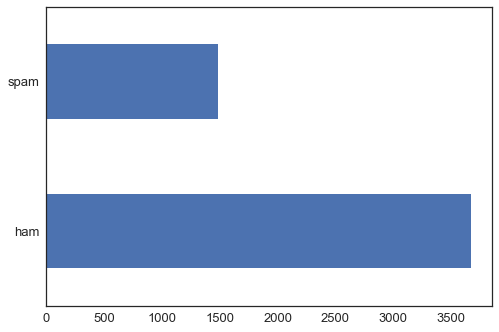

In [48]:
# how many of each type are there?
df_email.label.value_counts().plot(kind='barh')
df_email.label.value_counts()

### Build A Classifier - what's in our data?

In [49]:
'''TODO: Split training and testing data
   Use: 
       skcv.train_test_split(df_email, test_size=0.3, random_state=0)
       
   Save the result as:
       df_email_train, df_email_test
'''
df_email_train, df_email_test = skcv.train_test_split(df_email, test_size=0.3, random_state=0)

print ('Training data size:', len(df_email_train))
print ('Test data size:', len(df_email_test))

Training data size: 3609
Test data size: 1548


In [50]:
# let's "vectorize" the content
vectorizer = skft.CountVectorizer(max_df=0.7)
X_train = vectorizer.fit_transform(df_email_train.content)

In [94]:
df_email_train.head()

label                           title  \
836    ham  1162.2000-05-30.farmer.ham.txt   
1969   ham  2754.2000-11-02.farmer.ham.txt   
4689  spam     3624.2005-01-30.GP.spam.txt   
4000  spam     1182.2004-05-21.GP.spam.txt   
569    ham  0793.2000-03-29.farmer.ham.txt   

                                                content  
836   Subject: june ' s update\nhere is the lastest ...  
1969  Subject: re : revised allocation % ' s - octob...  
4689  Subject: uptick sharess\nmnei - the best small...  
4000  Subject: tutored best n @ k . ed lolitas . . ....  
569   Subject: april 1 noms\n- - - - - - - - - - - -...

In [51]:
'''TODO: concate all emails into one single string. 

   Use: 
         text_all = '\n'.join(df_email_train.content)
'''
text_all = '\n'.join(df_email_train.content)

'''TODO: tokenize text_all, and save the result as tokens_all.'''
tokens_all = text_all.split()

In [52]:
'''Lesson: to obtain the frequency distribution of tokens:

        nltk.probability.FreqDist(tokens_all)
'''

# TODO: obtain the frequency distribution from tokens_all, and save as fd
fd = nltk.probability.FreqDist(tokens_all)

In [53]:
'''Lesson: the fd generated above is essentially a Counter.
           To obtain the most common N objects from the counter, use:
              
              fd.most_common(N)
'''

# TODO: obtain the most common 20 tokens
fd.most_common(20)

[('-', 60651),
 ('.', 38585),
 ('/', 30737),
 (',', 28297),
 (':', 17983),
 ('the', 17800),
 ('to', 14121),
 ('ect', 10249),
 ('@', 9668),
 ('and', 8753),
 ('for', 7387),
 ('of', 6997),
 ('a', 6842),
 ("'", 5974),
 ('you', 5633),
 ('hou', 5355),
 ('in', 5329),
 ('>', 5138),
 ('on', 5036),
 ('is', 5003)]

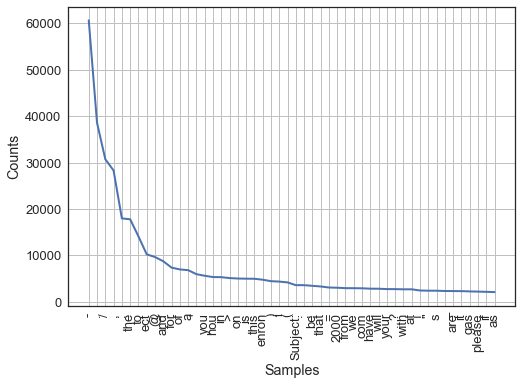

In [54]:
'''Lesson: to plot the frequency distribution of the top N frequent words, use:
    
    fd.plot(N)
'''

# TODO: plot the frequency distribution of top 50 frequent words
fd.plot(50)

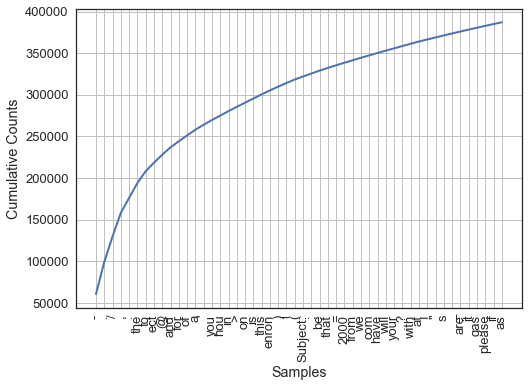

In [55]:
'''Lesson: to plot the cumulative frequency distributions of the top 50 frequent words, use:

      fd.plot(N, cumulative=True)
'''

# TODO: plot the cumulative frequency distribution of the top 50 frequent words
fd.plot(50, cumulative=True)

In [56]:
'''TODO: how many tokens are there in the training set?
      
      Hint: the length of tokens_all
'''
print ('There are %d tokens in the training set.'%len(tokens_all))

There are 826731 tokens in the training set.


In [57]:
'''TODO: how many *unique* tokens are there in the training set?

      Hint: the length of fd
'''
print ('There are %d unique tokens in the training set.'%len(fd))

There are 40828 unique tokens in the training set.


You should find that there are 826,731 tokens in the training set, and among them there are 40,828 unique tokens. Compare the first number with the above plot. You may see that the top 50 frequent token types take up almost a half of the token counts. This reminds us of the Pareto principle (also known as the 80–20 rule). 

### Build a classifier -- Making features
We will use a built-in module of `sklearn` to automatically calculate feature weights using tf-idf.

In [58]:
tfidf_transformer = skft.TfidfTransformer().fit(X_train)

'''Lesson: to use tfidf_transformer to calculate TFIDF weights, use:
 
       tfidf_transformer.transform(X)
'''

# TODO: Use tfidf_transformer to transform X_train, then save as X_train_tfidf
X_train_tfidf = tfidf_transformer.transform(X_train)

In [59]:
print ('Before transform:', X_train.shape)

Before transform: (3609, 40694)


In [60]:
print ('After transform:', X_train_tfidf.shape)

After transform: (3609, 40694)


From the above comparison, you can __notice that the shape of the matrix does not change after transformation__. It is the scale (magnitude) of each value in the matrix that has been changed.

### Train the Classifer

We will train a naive Bayes classifier. Notice that instead of using a Gaussian naive Bayes model as in the classification lab, we use a Multinomial naive Bayes model here, as the latter fits the actual type of distribution of the observed data.

In [61]:
'''Lesson: to create and fit a multinomial naive Bayes model, use

      sknb.MultinomialNB().fit(X, y)
'''

'''TODO: create and fit a multinomial naive Bayes model,
 
      X = X_train_tfidf
      y = df_email_train.label
   
   Save the model as nb_model
'''
nb_model = sknb.MultinomialNB().fit(X_train_tfidf, df_email_train.label)

Once trained, the model can be used for classifying new documents. Let's experiment with some made-up example.

In [62]:
s1 = 'where is the financial and marketing meeting this afternoon ?'

'''TODO: classify s1 into ham vs. spam.
      X_s1_counts = vectorizer.transform([s1])
      X_s1_tfidf = tfidf_transformer.transform(X_s1_counts)
      print ('Classification Result:', nb_model.predict(X_s1_tfidf)[0])
'''
X_s1_counts = vectorizer.transform([s1])
X_s1_tfidf = tfidf_transformer.transform(X_s1_counts)
print ('Classification Result:', nb_model.predict(X_s1_tfidf)[0])

Classification Result: ham


In [63]:
# TODO: classify s2 into ham vs. spam.
s2 = 'we sell prescription drugs ! call this number !'
X_s2_counts = vectorizer.transform([s2])
X_s2_tfidf = tfidf_transformer.transform(X_s2_counts)
print ('Classification Result:', nb_model.predict(X_s2_tfidf)[0])

Classification Result: spam


### Building a Pipeline
It can be tedious to do vectorization and tf-idf transformation for each new testing instance. We can build a `scikit-learn Pipeline` to automate the entire process.

Reference: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [64]:
pipeline = skpipe.Pipeline(
    [('vect', skft.CountVectorizer(max_df=0.7)),
     ('tfidf', skft.TfidfTransformer()),
     ('clf', sknb.MultinomialNB())])

pipeline.fit(df_email_train.content, df_email_train.label);

Question: 
We know that Naive Bayes Classifier assumes conditional independence among features, given a particular class.
So why is Naive Bayes "naive"?

Answer: 

In [65]:
# With this pipeline that serializes vectorizer, transformer, and classifier together, 
# classification becomes much easier.
print ('Clasification Result:', pipeline.predict(['you can earn money ! click here !'])[0])

Clasification Result: spam


In [66]:
'''TODO: come up with two fake emails (s3, and s4) so that s3 is classified as 'ham' and s4 'spam.'
'''
s3 = 'When should we meet?'
print ('Clasification Result:', pipeline.predict([s3])[0])

s4 = 'earn big money!'
print ('Clasification Result:', pipeline.predict([s4])[0])

Clasification Result: ham
Clasification Result: spam


### Evaluating the classifier

In [67]:
'''TODO: get predicted results and save as test_predicted.
   
   Hint: pipeline.predict(df_email_test.content)
'''

test_predicted = pipeline.predict(df_email_test.content)

In [68]:
'''TODO: get accuracy score.
      
   Hint: skmetrics.accuracy_score(true_labels, predicted_labels)
         true_labels is df_email_test.label
'''
print ('Accuracy:', skmetrics.accuracy_score(df_email_test.label, test_predicted))

Accuracy: 0.84819121447


<img src="precision_recall_f1score.jpg",width=700, height=100>

Our Goal: identify as many spam as possible with least amount of error

Positive: spam <br>
Negative: ham
Question:
#### 1. What does TP, TN, FP, FN mean in our ham/spam case, accoding to the definition and your understanding?
#### 2. What does Precision and Recall tell us? (if we're being aggresive, then we can have high recall; if we're being conservative, then we can have high precision)

Answer:

In [69]:
'''Lesson: to print a classification report, use:
     
      print (skmetrics.classification_report(true_labels, predicted_labels))
'''

# TODO: print the classification report on the test set
print (skmetrics.classification_report(df_email_test.label, test_predicted))

             precision    recall  f1-score   support

        ham       0.82      1.00      0.90      1078
       spam       1.00      0.50      0.67       470

avg / total       0.88      0.85      0.83      1548



In [70]:
print ((0.82 * 1078 + 1.0 * 470) /  (1078 + 470))
print ((1.0 * 1078 + 0.4 * 470) / (1078 + 470))

0.8746511627906977
0.8178294573643411


Question: 

precision: among all predictions, the classifier has ?% correct labels?
           among ham predictions, the classifier has ?% correct labels?
           among spam predictions, the classifier has ?% correct labels?

recall: among all e-mails, ? fraction did the classifier pick up?

In [71]:
'''TODO: get the confusion matrix. 

   Hint: skmetrics.confusion_matrix(true_labels, predicted_labels)
'''
confusion_matrix = pd.DataFrame(skmetrics.confusion_matrix(test_predicted, df_email_test.label),
                                index=['true spam','true ham'], 
                                columns=['predicted spam','predicted ham'])
confusion_matrix

predicted spam  predicted ham
true spam            1078            235
true ham                0            235

# Sentiment Analysis Again!

We will experiment lexicon-based sentiment analysis in this section.


__Reference__: The dataset was originally downloaded from http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/.

In [72]:
# Load up the sentiment lexicon.
import re
lexicon = {}
value_map = {'positive': 1, 'neutral': 0, 'negative': -1}
with open('subjectivity_clues_hltemnlp05/subjclueslen1-HLTEMNLP05.tff') as reader:
    for line in reader:
        m = re.match(".*\sword1=(\w+)\s.*priorpolarity=(positive|neutral|negative)", line)
        if m:
            m = m.groups()
            assert len(m) == 2
            lexicon[m[0]] = value_map[m[1]]

In [73]:
len(lexicon)

6714

In [74]:
'''Lesson: to get the sentiment score of a word, just use:

      lexicon[word]
'''

# TODO: sentiment score of 'happy'
lexicon['happy']

1

In [75]:
# TODO: sentiment score of 'sad'
lexicon['sad']

-1

In [76]:
# TODO: sentiment score of 'absolute'
lexicon['absolute']

0

Next, we apply this sentiment lexicon to classify movie reviews.

In [77]:
# Load the text files as a DataFrame.
titles = []
contents = []
labels = []
for label in ['pos', 'neg']:
    for f in os.listdir(os.path.join('review_polarity', 'txt_sentoken', label)):
        with open(os.path.join('review_polarity', 'txt_sentoken', label, f), 'r') as reader:
            try:
                c = reader.read()
            except:
                continue
            contents.append(c)
            titles.append(f)
            labels.append(label)
df_review = pd.DataFrame({'title': titles, 'content': contents, 'label': labels},
                         columns = ['label', 'title', 'content'])

In [78]:
df_review.head()

label            title                                            content
0   pos  cv000_29590.txt  films adapted from comic books have had plenty...
1   pos  cv001_18431.txt  every now and then a movie comes along from a ...
2   pos  cv002_15918.txt  you've got mail works alot better than it dese...
3   pos  cv003_11664.txt   " jaws " is a rare film that grabs your atten...
4   pos  cv004_11636.txt  moviemaking is a lot like being the general ma...

In [79]:
df_review.shape

(2000, 3)

In [80]:
'''TODO: Check the distribution of labels
   
   Hint:
      df_review.label.value_counts()
'''
df_review.label.value_counts()

neg    1000
pos    1000
Name: label, dtype: int64

In [81]:
# Define a naive lexicon-based sentiment classifier. It will look at each document
# adding values for positive words and subtracting for negative ones
# if the end score is positive we return 'pos' otherwise we return 'neg'
def get_sentiment(lexicon, s):
    tokens = s.lower().split()
    tokens = map(stemmer.stem, tokens)
    scores = [lexicon[t] for t in tokens if t in lexicon]
    return 'pos' if sum(scores) > 0 else 'neg'

In [82]:
'''Lesson: to classify the sentiment of a sentence, use
      get_sentiment(lexicon, sentence)
'''

# TODO: sentiment of sentence="I love this movie !"
get_sentiment(lexicon, 'I love this movie !')

'pos'

In [83]:
# TODO: sentiment of sentence="it is such a boring movie"
get_sentiment(lexicon, 'it is such a boring movie')

'neg'

In [84]:
'''TODO: Make prediction for every single movie in the dataset
  
   Hint: 
   
      predicted_labels = [get_sentiment(lexicon, x) for x in df_review.content]

This may take a while...
'''
predicted_labels = [get_sentiment(lexicon, x) for x in df_review.content]

In [85]:
'''TODO: get accuracy score of the prediction.

      Hint: true label is df_review.label
'''
skmetrics.accuracy_score(df_review.label, predicted_labels)

0.60550000000000004

In [86]:
# TODO: print a classification report
print (skmetrics.classification_report(df_review.label, predicted_labels))

             precision    recall  f1-score   support

        neg       0.66      0.43      0.52      1000
        pos       0.58      0.78      0.66      1000

avg / total       0.62      0.61      0.59      2000



In [87]:
# TODO: print the confusion matrix
skmetrics.confusion_matrix(df_review.label, predicted_labels)

array([[434, 566],
       [223, 777]])

### Topic Modelling Again

Let's run topic modelling on the reviews

In [88]:
# Run LDA on the review dataset.
n_features = 1000
n_topics = 10
n_top_words = 20

# "tf" stands for "term frequency"
tf_vectorizer = skft.CountVectorizer(max_df=0.7, min_df=2, max_features=n_features, stop_words='english')
tf_reviews = tf_vectorizer.fit_transform(df_review.content)

In [89]:
lda = skd.LatentDirichletAllocation(n_topics=n_topics, 
                                    max_iter=10,
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0)

In [90]:
'''TODO: Fit the LDA model using:
        
        lda.fit(tf_reviews);
        
   This may take a while running in the backend
'''
lda.fit(tf_reviews);

In [91]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print("Topics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topics in LDA model:
Topic #0:
disney batman murphy animated robin story eddie ryan children animation king tarzan family voice tarantino time war jackson brown little
Topic #1:
just bad time really plot good don know character films people characters story action scenes make way movies effects ve
Topic #2:
scream jackie horror films school high girls truman max chan characters movies carrey mr just hong teen know summer best
Topic #3:
killer murder thriller detective mystery suspense seven death blood police final genre dark john fear victim body premise kill mind
Topic #4:
smith kevin wild west bob american comic line rock black red jokes war director point van ben comes god version
Topic #5:
alien star ship effects time new aliens planet earth series story crew godzilla human trek just science deep good special
Topic #6:
story life character characters time man love just does good director best way scene make performance doesn little people great
Topic #7:
funny kevin life character

Now we start to see some more interesting patterns 

Topic 0 seems to be about comic and kid movies

Topic 1 is generically about good and bad facets (plot, character, etc.)

Topics 2 and 3 seem related to horror

Topic 4 seems to be about comedies

Topic 5 is about scifi

and so on...

You can vary the number of topics to see what happens.

In [92]:
## Based on the above topic keywords, replace abcd with what you think each topic is about
topic1 = "comic and kid movies"
topic2 = "b"
topic3 = "c"
topic4 = "d"
topic5 = "e"
topic6 = "f"
topic7 = "g"
topic8 = "h"
topic9 = "i"
topic10 = "j"
topics = [topic1, topic2, topic3, topic4, topic5, topic6, topic7, topic8, topic9, topic10]

In [93]:
# get documents per topic in LDA
for n in range(doc_topic.shape[0]):
    print("doc: {} topic: {}\n".format(n,topic_most_pr))
    for p in range(len(doc_topic[n])):
        print("topic: {} ({}%)".format(topics[p], round(doc_topic[n][p]*100, 3)))
    print("\n")
   

NameError: name 'doc_topic' is not defined